# Pytorch Model/Layer

* [PyTorch Forum - How to access to a layer by module name?](https://discuss.pytorch.org/t/how-to-access-to-a-layer-by-module-name/83797/2)

In [1]:
import os
import sys
from itertools import (
    product
)
from typing import (
    List,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix
)
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import (
    SummaryWriter,
)

In [2]:
%load_ext tensorboard

In [3]:
%load_ext autoreload
%autoreload 2
from lib.util_torch import (    # PYTHONPATH points to the library parent.
    get_image_data_mean_std,
    get_accuracy_multi_labels,
    tensorboard_write_histogram,
    tensorboard_write_graph,
    tensorboard_write_image,
    tensorboard_write_scalar,
    tensorboard_write_scalars,
    plot_confusion_matrix,
    tensorboard_write_confusion_matrix,
)

# Data

## Train & Validation Dataset

### Calculate the mean and std of the pixels (features) per each channel

In [4]:
dataset_train = FashionMNIST(
    os.getcwd(), 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=8)
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:41<00:00, 641203.18it/s]


Extracting /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 51405.10it/s]


Extracting /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1876159.36it/s]


Extracting /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 457793.26it/s]

Extracting /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/oonisim/home/repository/git/oonisim/python-programs/pytorch/model/FashionMNIST/raw



### Normalize the image pixels (features)

In [5]:
dataset_train = FashionMNIST(
    os.getcwd(), 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)

### Verify the std/mean of normalized 

In [6]:
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=8)
)
print(f"(mean, std)={mean, std}")

(mean, std)=(tensor([-7.7892e-07]), tensor([1.0027]))


### Data loaders

In [7]:
train_size = int(0.9 * len(dataset_train))
val_size = len(dataset_train) - train_size
training_data, val_data = torch.utils.data.random_split(dataset_train, [train_size, val_size])

# train_loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_size,  shuffle=True, num_workers=0)

## Test Dataset

### Data Loader

In [8]:
dataset_test = FashionMNIST(
    os.getcwd(), 
    train=False,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)
test_size: int = len(dataset_test)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_size, shuffle=True, num_workers=0)

## Labels

In [9]:
id_to_label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
list(id_to_label.values())

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle Boot']

## Sample image

In [10]:
X, Y = next(iter(val_loader))
x = X[0]
y = Y[0]

channels: int = x.shape[0]
width: int = x.shape[1]
height: int = x.shape[2]
(channels, width, height)

(1, 28, 28)

Bag


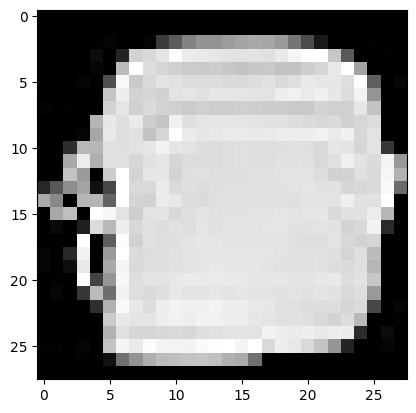

In [11]:
print(id_to_label.get(y.item()))
plt.imshow(x.squeeze(), cmap="gray")

---

# Model

## Convolution
* Start the kernel size with ```(3x3)``` which is default for defact CNN models.
* Use small kernel size e.g. ```(2x2)``` for low resolution image e.g. MNIST or CIFAR10.
* Smaller kernel size e.g. ```(3x3)``` or ```(5x5)``` is better even when resolution is high.

In [12]:
class ConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(channels, 16, kernel_size=3, padding="same"),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, padding="same"),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(p=0.2, inplace=False),
      nn.Linear(width * height * 32 // 16, 32),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

---


# Hyper Parameters

In [13]:
batch_sizes: List[int] = [
    8
]
learning_rates: List[float] = [
    1e-5
]
beta1s: List[float] = [
    0.95
]
beta2s: List[float] = [
    0.999
]
decays: List[float] = [
    0.015
]

# Training Loop

In [14]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [15]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS: int = 2

In [16]:
%rm -rf ./logs

In [17]:
max_test_acc: float = 0.0
writer = None

for batch_size, lr, beta1, beta2, decay in product(batch_sizes, learning_rates, beta1s, beta2s, decays):
    run_name: str = f"./logs/batch{batch_size}_lr{lr}_beta1{beta1}_beta2{beta2}_decay{decay}"

    print()
    print('-' * 80)
    print(f"batch_size:{batch_size} lr:{lr} beta1:{beta1} beta2:{beta2} decay:{decay}")
    print('-' * 80)

    # --------------------------------------------------------------------------------
    # Initialize at new parameter combination.
    # --------------------------------------------------------------------------------
    prev_loss: float = float(sys.maxsize)
    early_stop_tolerance: int = 3

    if isinstance(writer, SummaryWriter):
        writer.close()

    writer = SummaryWriter(run_name)

    # num_workers=0 to avoid the issue in https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/19
    train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
    model: nn.Module = ConvNet()
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')   # normalized by batch size

    # --------------------------------------------------------------------------------
    # Train for each parameter combination.
    # --------------------------------------------------------------------------------
    for epoch in range(0, NUM_EPOCHS):
        print(f'Starting epoch:[{epoch}].')
        tensorboard_write_histogram(writer=writer, model=model, step=epoch)


        _cumulative_loss: float = 0.0    # Reset cumulative training loss during an epoch
        _train_loss: float = 0.0         # Reset training loss during an epoch
        model.train(True)
        for index, data in enumerate(train_loader, 0):
            inputs, labels = data
            _batch_size: int = len(inputs)

            # Write an image at every batch 0
            if index == 0:
                tensorboard_write_image(
                    writer=writer, tag="image", image=inputs[0], step=epoch, dataformats="CHW"
                )

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs.to(device))

            # Compute loss
            loss = loss_fn(outputs, labels.to(device))

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            _cumulative_loss += loss.item()
            _train_loss = _cumulative_loss / (index + 1)

            if index % 1000 == 0:
                print(f'training loss at batch:[{index:05d}]: {_train_loss:.03f}')

            # if index > 209: break

        # --------------------------------------------------------------------------------
        # Reports per epoch
        # --------------------------------------------------------------------------------
        model.eval()

        # Accuracy & confusion matrix
        inputs = labels = predictions = None
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))

            predictions = model(inputs.to(device))
            val_loss = loss_fn(predictions, labels.to(device))

        val_acc = get_accuracy_multi_labels(predictions=predictions.cpu(), labels=labels)

        # Loss
        tensorboard_write_scalars(
            writer=writer,
            tag="loss",
            tag_scalar_dict={
                "training" : _train_loss,
                "validation" : val_loss
            },
            step=epoch
        )
        tensorboard_write_scalar(
            writer=writer, tag="validation accuracy/epoch", value=val_acc, step=epoch
        )
        tensorboard_write_confusion_matrix(
            writer=writer,
            tag="validation confusion matrix",
            predictions=torch.argmax(predictions.cpu(), axis=-1),
            truth=labels,
            class_names=list(id_to_label.values()),
            step=epoch
        )
        print(f'val_acc {val_acc:.03f} val_loss {val_loss: .03f}')
        writer.flush()

        # --------------------------------------------------------------------------------
        # Early stop
        # --------------------------------------------------------------------------------
        if val_loss > prev_loss:
            early_stop_tolerance -= 1
        else:
            prev_loss = val_loss

        if early_stop_tolerance <= 0:
            print("early stop")
            break

    # --------------------------------------------------------------------------------
    # Test
    # --------------------------------------------------------------------------------
    inputs = labels = predictions = None
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        predictions = model(inputs.to(device))

    test_loss = loss_fn(predictions, labels.to(device))
    test_acc = get_accuracy_multi_labels(predictions=predictions.cpu(), labels=labels)
    print(f'test_acc {test_acc:.03f} test_loss {test_loss: .03f}')

    # Report test results
    tensorboard_write_scalar(
        writer=writer, tag="loss", value=test_loss, step=epoch
    )
    tensorboard_write_scalar(
        writer=writer, tag="accuracy", value=test_acc, step=epoch
    )
    tensorboard_write_confusion_matrix(
        writer=writer,
        tag="test confusion matrix",
        predictions=torch.argmax(predictions.cpu(), axis=-1),
        truth=labels,
        class_names=list(id_to_label.values()),
        step=epoch
    )
    writer.add_hparams(
        hparam_dict={"batch": batch_size, "lr": lr, "beta1": beta1, "beta2": beta2, "decay": decay},
        metric_dict={
            "test_accuracy": test_acc,
            "test_loss": test_loss,
        },
        run_name=run_name,
    )
    writer.flush()

    # Save model if the accuracy is better
    if max_test_acc < test_acc:
        print()
        print(f"max test accuracy:[{test_acc}] with batch:{batch_size} lr:{lr} beta1:{beta1} beta2:{beta2} decay:{decay}")
        max_test_acc = test_acc

        print(f"saving the model as model.pth...")
        torch.save(model, 'model.pth')


# Process is complete.
print('Training process has finished.')


--------------------------------------------------------------------------------
batch_size:8 lr:1e-05 beta1:0.95 beta2:0.999 decay:0.015
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.315
training loss at batch:[01000]: 2.170
training loss at batch:[02000]: 1.996
training loss at batch:[03000]: 1.827
training loss at batch:[04000]: 1.673
training loss at batch:[05000]: 1.540
training loss at batch:[06000]: 1.431
val_acc 0.745 val_loss  0.788
Starting epoch:[1].
training loss at batch:[00000]: 0.958
training loss at batch:[01000]: 0.764
training loss at batch:[02000]: 0.734
training loss at batch:[03000]: 0.721
training loss at batch:[04000]: 0.706
training loss at batch:[05000]: 0.693
training loss at batch:[06000]: 0.682
val_acc 0.789 val_loss  0.594
test_acc 0.477 test_loss  1.717

max test accuracy:[0.4772] with batch:8 lr:1e-05 beta1:0.95 beta2:0.999 decay:0.015
saving the model as model.pth..

# Tensorboard

In [18]:
%tensorboard --logdir ./logs/

---
# Model layers

In [19]:
model

ConvNet(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1568, out_features=32, bias=True)
    (11): Linear(in_features=32, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=32, bias=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Access layers

In [20]:
conv2d_01 = model.layers[0]
maxpol_01 = model.layers[2]
conv2d_04 = model.layers[4]

### Conv2D filters

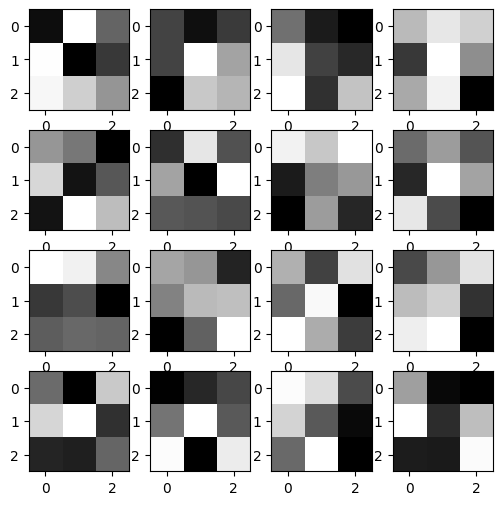

In [22]:
_, axs = plt.subplots(4, 4, figsize=(6, 6))
axs = axs.flatten()
for img, ax in zip(conv2d_01.cpu().weight.squeeze().detach().numpy(), axs):
    ax.imshow(img, cmap='gray')
plt.show()

### Convluated images

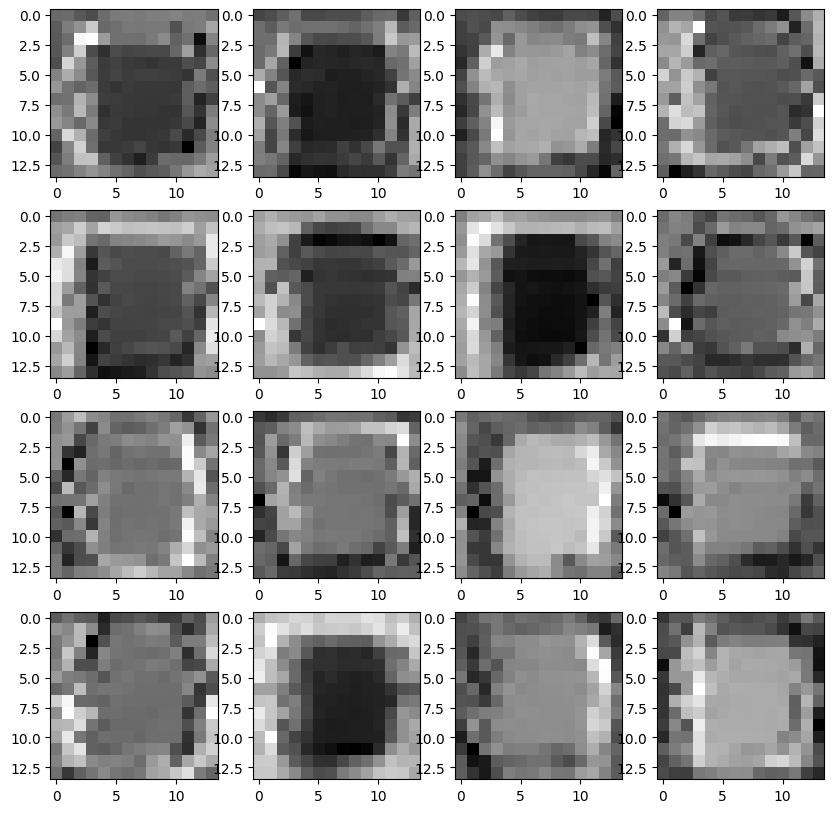

In [27]:
convoluted = conv2d_04.cpu()(maxpol_01.cpu()(conv2d_01.cpu()(x)))
_, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(convoluted.detach().numpy(), axs):
    ax.imshow(img, cmap='gray')
plt.show()

# Cleanup

In [ ]:
writer.close()